<details><summary style="display:list-item; font-size:16px; color:blue;">Jupyter Help</summary>
    
Having trouble testing your work? Double-check that you have followed the steps below to write, run, save, and test your code!
    
[Click here for a walkthrough GIF of the steps below](https://static-assets.codecademy.com/Courses/ds-python/jupyter-help.gif)

Run all initial cells to import libraries and datasets. Then follow these steps for each question:
    
1. Add your solution to the cell with `## YOUR SOLUTION HERE ## `.
2. Run the cell by selecting the `Run` button or the `Shift`+`Enter` keys.
3. Save your work by selecting the `Save` button, the `command`+`s` keys (Mac), or `control`+`s` keys (Windows).
4. Select the `Test Work` button at the bottom left to test your work.

![Screenshot of the buttons at the top of a Jupyter Notebook. The Run and Save buttons are highlighted](https://static-assets.codecademy.com/Paths/ds-python/jupyter-buttons.png)

**Setup**
Run the following cell to import libraries.

**MLP Task: Predict Hotel Cancellations Using Booking Data**

In this exercise, you will use PyTorch and neural networks to predict hotel cancellations using [real-world hotel booking data](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand) from a resort hotel. 

The goal is to build a neural network that can predict whether a reservation will be canceled ahead of time using features like the date of the booking, the length of stay, the number of people staying, and the average daily rate.

The testing dataset has already been cleaned and pre-processed. It is loaded into PyTorch dataset objects `test_dataset` and `test_loader` for batching and placed onto the GPU device.

In [1]:
# Load test data
import torch
import pandas as pd
import numpy as np
torch.manual_seed(42)

# Load Testing data
TEST_CSV  = "datasets/bookings_test.csv"
test_df  = pd.read_csv(TEST_CSV)

# Testing Features + Target Distribution
TARGET = "is_canceled"
input_features = [x for x in test_df.columns if x not in TARGET]
print("# of Input Features:", len(input_features))
print()

print("Testing Target Distribution:")
print(test_df[TARGET].value_counts().to_frame("count").assign(pct=lambda x: (x["count"] / x["count"].sum() * 100).round(2)))
print()

# Load to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test = torch.from_numpy(test_df[input_features].values).float().to(device)
y_test = torch.from_numpy(test_df[TARGET].values).float().view(-1, 1).to(device)

y_true = y_test.cpu().numpy().ravel()
print("Testing size:", y_test.shape)

# Create TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check device
print("Device:", device)

# of Input Features: 155

Testing Target Distribution:
             count   pct
is_canceled             
0             2224  50.0
1             2224  50.0

Testing size: torch.Size([4448, 1])
Device: cuda


#### Checkpoint 1/3

Let's use our trained MLP to predict cancellations on the testing set. 

Instead of re-training the MLP again, we can use the trained weights to save time and resources.

**A.** Re-create an instance of the `SimpleMLP` class with an input feature size of `155`, hidden size of `360`, and output size of `1`. Save the model to the variable `mlp_relu`.

**B.** Load the pre-trained weights saved in `models/mlp_relu_weights.pt` to the variable `state_dict` and load them to the model `mlp_relu`.

Don't forget to run the cell and save the notebook before selecting `Test Work`! Open the `Jupyter Help` toggle at the top of the notebook for more details.

In [2]:
import torch
import torch.nn as nn
torch.manual_seed(42)

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1   = nn.Linear(input_size, hidden_size)
        self.fc2   = nn.Linear(hidden_size, hidden_size)
        self.fc3   = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

## YOUR SOLUTION HERE ##
input_features = 155
hidden_neurons = 360
output_classes = 1
mlp_relu = SimpleMLP(input_features, hidden_neurons, output_classes)

state_dict = torch.load(
    "models/mlp_relu_weights.pt",
    map_location = device,
    weights_only = True
)
mlp_relu.load_state_dict(state_dict)

# Move to GPU device -- DO NOT MODIFY
mlp_relu.to(device)

SimpleMLP(
  (fc1): Linear(in_features=155, out_features=360, bias=True)
  (fc2): Linear(in_features=360, out_features=360, bias=True)
  (fc3): Linear(in_features=360, out_features=1, bias=True)
  (relu): ReLU()
)

#### Checkpoint 2/3

Let's create the function `predict` for our prediction loop. The prediction loop should also convert the logits to predicted labels and return the following:
- `avg_loss`: The average loss across all batches.
- `acc`: The accuracy performance of the full testing set.

**A.**: Build the prediction loop as follows:
1. Initialize empty lists for all the logits (`all_logits`) and predictions (`all_predictions`).
2. Iterate over the batched data (and move them to the correct device).
3. For each batch:
   - Input through the forward pass to obtain the logits.
   - Convert the logits to predicted labels (`preds`).
   - Append the batch logits and labels to `all_logits` and `all_predictions`.
4. Return the complete list of predicted logits and labels (in that order).

**B.**: Use the function to generate test predictions from `mlp_relu`. Save the logits to `y_logits_relu` and `y_pred_relu`.

Don't forget to run the cell and save the notebook before selecting `Test Work`! Open the `Jupyter Help` toggle at the top of the notebook for more details.

In [5]:
import numpy as np
import torch

## YOUR SOLUTION HERE ##
def predict(model, dataloader, device="cpu"):
    model.eval()
    all_logits = []
    all_predictions = [] 

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            logits = model(batch_X)

            # Convert logits to predicted labels
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            
            all_logits.append(logits.cpu().numpy())
            all_predictions.append(preds.cpu().numpy())
            

    y_logits = np.concatenate(all_logits).ravel()
    y_pred = np.concatenate(all_predictions).ravel()

    return y_logits, y_pred

y_logits_relu, y_pred_relu = predict(mlp_relu, test_loader, device=device)

#### Checkpoint 3/3

Evaluate the MLP's predictions by calculating the overall accuracy and creating a classification report.

**A.** Save the overall accuracy to the variable `test_accuracy`.

**B.** Save the classification report to the variable `report`.

Don't forget to run the cell and save the notebook before selecting `Test Work`! Open the `Jupyter Help` toggle at the top of the notebook for more details.ook for more det

In [6]:
## YOUR SOLUTION HERE ##
from sklearn.metrics import accuracy_score, classification_report
test_accuracy = accuracy_score(y_true, y_pred_relu)
report = classification_report(y_true, y_pred_relu, target_names=['Not Canceled', 'Canceled'])

print(f"Accuracy: {test_accuracy:.4f}")
print(report)

Accuracy: 0.7961
              precision    recall  f1-score   support

Not Canceled       0.78      0.83      0.80      2224
    Canceled       0.82      0.76      0.79      2224

    accuracy                           0.80      4448
   macro avg       0.80      0.80      0.80      4448
weighted avg       0.80      0.80      0.80      4448



#### Summary

An overall accuracy of ~80% suggests that the model performs reasonably well.

**Class-Level Performance**
- Not Canceled (Class 0): Precision = 0.78 and Recall = 0.83
- Canceled (Class 1): Precision = 0.82 and Recall = 0.76
- Both Classes: F1-score 0.79-0.80

The model achieves a solid, well-balanced performance for both classes. 

In the next exercise, you'll learn more different types of activation functions and layers that may help improve performance.

#### Optional Checkpoint

Visualize the distribution of prediction counts.

{'Not Canceled': 2373, 'Canceled': 2075}


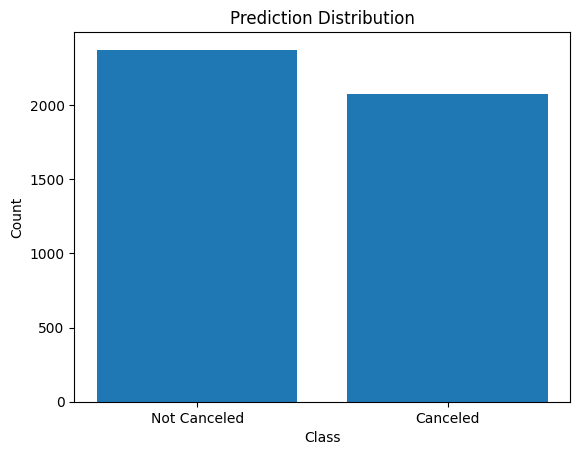

In [7]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# Prediction counts
class_map = {0: "Not Canceled", 1: "Canceled"}
counts = {class_map[k]: v for k, v in Counter(y_pred_relu).items()}
print(counts)

# Visualize counts
plt.bar(counts.keys(), counts.values())
plt.title("Prediction Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()